In [1]:
# Term Frequency-Inverse Document Frequency (TFIDF) Attempt

In [1]:
# import packages

import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

os.chdir("..")
from scripts import data_preprocessing

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
os.getcwd()

'C:\\Users\\Chris\\Desktop\\MIDS\\Spring_2022\\AIPI_DeepLearning\\GeneralizingSentiment'

In [3]:
# import data

labeled_df = pd.read_parquet("data/data_prepipeline/full_raw_data.parquet.gzip")

In [4]:
labeled_df = labeled_df.sample(25000)

In [5]:
cleaned_df = data_preprocessing.proprocessing(labeled_df.text)
labeled_df["text_cleaned"] = cleaned_df.str[0]

In [6]:
labeled_df['sentiment_id'] = labeled_df['sentiment']
labeled_df['sentiment_id'] = labeled_df['sentiment_id'].replace("negative", 0)
labeled_df['sentiment_id'] = labeled_df['sentiment_id'].replace("neutral", 1)
labeled_df['sentiment_id'] = labeled_df['sentiment_id'].replace("positive", 2)
labeled_df['sentiment_id'].value_counts()

2    18368
1     4294
0     2338
Name: sentiment_id, dtype: int64

In [7]:
labeled_df['sentiment'].value_counts()

positive    18368
neutral      4294
negative     2338
Name: sentiment, dtype: int64

<AxesSubplot:>

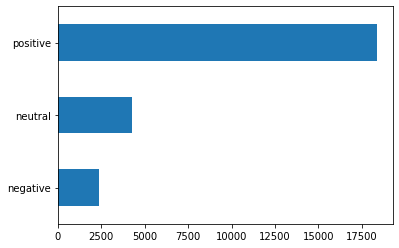

In [8]:
labeled_df['sentiment'].value_counts().sort_values().plot(kind = 'barh')

In [9]:
labeled_df.sentiment_id.value_counts()

2    18368
1     4294
0     2338
Name: sentiment_id, dtype: int64

In [10]:
# Undersample to handle unbalanced dataset

# Class count
count_class_2, count_class_1, count_class_0 = labeled_df.sentiment_id.value_counts()

print(f'Postive Class Count {count_class_2}')
print(f'Neutral Class Count {count_class_1}')
print(f'Negative Class Count {count_class_0}')

Postive Class Count 18368
Neutral Class Count 4294
Negative Class Count 2338


Random under-sampling:
negative    2338
neutral     2338
positive    2338
Name: sentiment, dtype: int64


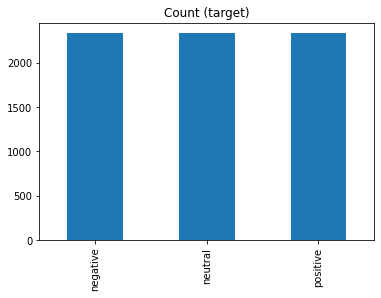

In [11]:
df_class_0 = labeled_df[labeled_df['sentiment_id'] == 0]
df_class_1 = labeled_df[labeled_df['sentiment_id'] == 1]
df_class_2 = labeled_df[labeled_df['sentiment_id'] == 2]

df_class_1_under = df_class_1.sample(count_class_0)
df_class_2_under = df_class_2.sample(count_class_0)
undersample_df_cleaned = pd.concat([df_class_0, df_class_1_under, df_class_2_under], axis=0)

print('Random under-sampling:')
print(undersample_df_cleaned.sentiment.value_counts())

undersample_df_cleaned.sentiment.value_counts().plot(kind='bar', title='Count (target)');

In [12]:
undersample_df_cleaned.head()

,sentiment,text,text_cleaned,sentiment_id
6745,negative,@SouthwestAir its cool that my bags take a bit...,southwestair its cool that my bags take a bit ...,0
5167,negative,"Still Rattled By Trump's Tweet, Jimmy Kimmel B...",still rattled by trumps tweet jimmy kimmel bla...,0
754114,negative,The picture was graining and I could understan...,the picture was graining and i could understan...,0
1280165,negative,Liam Neeson has a well-respected history of ne...,liam neeson has a wellrespected history of nev...,0
1295843,negative,I love the show. It's my favorite on Nick and ...,i love the show its my favorite on nick and im...,0


In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')
# We transform each complaint into a vector
features = tfidf.fit_transform(undersample_df_cleaned.text_cleaned).toarray()
labels = undersample_df_cleaned.sentiment_id
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 7014 complaints is represented by 15481 features (TF-IDF score of unigrams and bigrams)


In [14]:
# Create a new column 'category_id' with encoded categories 
category_id_df = undersample_df_cleaned[['sentiment', 'sentiment_id']].drop_duplicates()

In [15]:
category_id_df.values

array([['negative', 0],
       ['neutral', 1],
       ['positive', 2]], dtype=object)

In [16]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sentiment_id', 'sentiment']].values)

In [17]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

n==> negative:
  * Most Correlated Unigrams are: worst, money, waste
  * Most Correlated Bigrams are: waste money, dont waste, waste time
n==> neutral:
  * Most Correlated Unigrams are: okay, pretty, ok
  * Most Correlated Bigrams are: movie okay, waste time, pretty good
n==> positive:
  * Most Correlated Unigrams are: loved, love, great
  * Most Correlated Bigrams are: love movie, highly recommend, great movie


In [32]:
# build model

X = undersample_df_cleaned['text_cleaned'] # Collection of documents
y = undersample_df_cleaned['sentiment_id'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [33]:
# importing the relevant modules
from sklearn.feature_extraction.text import CountVectorizer

# vectorizing the sentences
cv = CountVectorizer(binary = True) # implies that it indicates whether the word is present or not.

cv.fit(X) # find all the unique words from the training set

X_train_vec = cv.transform(X_train)
X_test_vec = cv.transform(X_test)

In [34]:
# importing the relevant modules
import xgboost as xgb

# creating a variable for the new train and test sets
xgb_train = xgb.DMatrix(X_train_vec, y_train)
xgb_test = xgb.DMatrix(X_test_vec, y_test)

In [59]:
from sklearn.metrics import accuracy_score, f1_score

# Setting the Parameters of the Model
param = {'eta': 1,
         'max_depth': 50,
         'num_class': 3,
         'objective': 'multi:softmax'}
 
# Training the Model
xgb_model = xgb.train(param, xgb_train, num_boost_round = 30)
# Predicting using the Model
y_pred = xgb_model.predict(xgb_test)
y_pred = np.where(np.array(y_pred) > 0.5, 1, 0) # converting them to 1/0’s
# Evaluation of Model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')                 
print(f'F1 Weighted: {f1_score(y_test, y_pred, average="micro")}')    

[10:30:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.4766248574686431
F1 Weighted: 0.4766248574686431


In [48]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [49]:
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [50]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [51]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.689337,0.008242
LogisticRegression,0.704165,0.019272
MultinomialNB,0.699316,0.012529
RandomForestClassifier,0.599375,0.012736


In [52]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
# Hyper tune best results

# random search logistic regression model on the sonar dataset
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer

# build model

X = undersample_df_cleaned['text_cleaned'] # Collection of documents
y = undersample_df_cleaned['sentiment_id'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

X_train_vec = tfidf.fit_transform(X_train).toarray()
X_test_vec = tfidf.fit_transform(X_test).toarray()

model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1, )
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1, verbose=10)
# execute search
result = search.fit(X_train_vec, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 30 folds for each of 500 candidates, totalling 15000 fits


KeyboardInterrupt: 